# Programming Assignment

### 1. Libraries

In [564]:
import networkx as nx
from IPython.display import Image, display
import json
from graphviz import Digraph
from networkx.algorithms.minors import quotient_graph
import string



### 2. Read the input and check for a valid regex

In [565]:
# Read the input from the user 
input_regex = r"a?(a|b)*?b"

### 3. Preprocessing 
<P>check operators error</P>
<P>Add concatenation character</P>


In [566]:

CONCAT_SYMBOL = "#"

def insert_concat_symbol(regex):
    result = ""
    operators = ["?", "*", "|", "+"]
    inside_brackets = False
    for i in range(len(regex)):
        if regex[i] == "[":
            inside_brackets = True
        elif regex[i] == "]":
            inside_brackets = False

        if (
            not inside_brackets
            and i < len(regex) - 1
            and regex[i + 1] not in operators
            and regex[i] != "|"
            and regex[i] != "("
            and regex[i + 1] != ")"
            and regex[i] != "["
            and regex[i + 1] != "]"
        ):
            result += regex[i] + CONCAT_SYMBOL
        else:
            result += regex[i]      
    return result

def check_operator_error(regex):
    operators = "?*+"
    for i, char in enumerate(regex):
        if char in operators + "|"  :
            # corresponding operators
            if i < len(regex) - 1 and regex[i+1] in operators: 
                raise ValueError('Mismatched operators')
            # check oring error
            if char == '|' and not (i > 0 and i < len(regex) - 1):
                raise ValueError('Mismatched | operator')
            if char in operators and not i > 0:
                raise ValueError('Mismatched operator')
            

def preprocess_regex(regex):
    check_operator_error(regex)
    new_regex = insert_concat_symbol(regex)        
    return new_regex    

### 4. Shunting yard algorithm 
<P>Convert infix regex to postfix regex</P>

In [567]:
def shunting_yard(input_regex):
    # Define precedence
    """
        * : 0 or more repetition
        + : 1 or more repetition
        # : concatenation
        . : Any single character
        | : OR
    """
    
    precedence = {
    '*': 6,  # 0 or more repetition
    '+': 5,  # 1 or more repetition
    '?': 4,  # optional (exists or not)
    '#': 3,  # concatenation operator
    '.': 2,  # any single character
    '|': 1   # OR operator
    }
    
    # postfix_output queue and operator operator_stack
    postfix_output = []
    operator_stack = []
    alphanumeric = string.ascii_letters + string.digits
    inside_bracket_ranges = False

    # Process each character in the input
    i = 0
    while i < len(input_regex):
        char = input_regex[i]

        if char == '[':
            start = i
            while i < len(input_regex) and input_regex[i] != ']':
                i += 1
            if i < len(input_regex):
                postfix_output.append(input_regex[start:i+1])  # Include the ']'
                i += 1
            continue

        if char == '(':
            operator_stack.append(char)
        elif char == ')':
            while operator_stack and operator_stack[-1] != '(':
                postfix_output.append(operator_stack.pop())
            if not operator_stack:
                raise ValueError('Mismatched closing parenthesis')
            operator_stack.pop()  
        elif char in precedence:
            while operator_stack and operator_stack[-1] in precedence and precedence[char] <= precedence[operator_stack[-1]]:
                postfix_output.append(operator_stack.pop())
            operator_stack.append(char)  
        else:
            postfix_output.append(char)
        i += 1

    # Pop remaining operators from the operator_stack to the postfix_output
    while operator_stack:
        # check operator_stack error if there is still '(' in the operator_stack so it won't have a close ')'
        if operator_stack[-1] == '(':
            raise ValueError('Mismatched openning parenthesis')
            return None
        elif operator_stack[-1] == '[':
            raise ValueError('Mismatched openning square bracket')
            return None
        postfix_output.append(operator_stack.pop())

    # Return the postfix_output as a string
    return ''.join(postfix_output)


### 5. Convert postfix regex to NFA using thomson's rule

In [568]:
global state_counter
state_counter = 0

def graph_to_json(G):
    """
    Convert a graph to a JSON structure, supporting multiple transitions for the same input symbol,
    with states and transitions sorted. Assume the starting state is the minimum one
    and the terminating state is the maximum one.
    """
    nodes_sorted = sorted(G.nodes(), key=lambda x: (isinstance(x, int), x))
    starting_state = str(nodes_sorted[0])
    terminating_states = [] 
    # loop on each node in graph and check if terminating state or not
    for node, data in G.nodes(data=True):
        if node == nodes_sorted[-1] or (data and data['is_terminating']):
            terminating_states.append(str(node))

    # Create the JSON structure
    graph_dict = {"startingState": f"S{starting_state}"}
    
    for node in sorted(G.nodes(), key=lambda x: (isinstance(x, int), x)):
        node_entry = {"isTerminatingState": str(node) in terminating_states}
        
        transitions = {}
        for edge in sorted(G.out_edges(node, data=True), key=lambda e: e[2]['symbol']):
            symbol, target_state = edge[2]['symbol'], edge[1]
            if symbol in transitions:
                transitions[symbol] = transitions[symbol] if isinstance(transitions[symbol], list) else [transitions[symbol]]
                transitions[symbol].append(str(f"S{target_state}"))
            else:
                transitions[symbol] = str(f"S{target_state}")
        
        node_entry.update({symbol: target if isinstance(target, list) and len(target) > 1 else target[0] if isinstance(target, list) else target 
                        for symbol, target in sorted(transitions.items(), key=lambda item: item[0])})
        
        graph_dict[str(f"S{node}")] = node_entry

    return json.dumps(graph_dict, indent=2, ensure_ascii=False)

def draw_graph(G, filename):
    """
    Draws the NFA using Graphviz with symbols on the edges and highlights the start node (the one with the minimum state number)
    and the end node (the one with the maximum state number).
    """
    if G.nodes():
        start_state = min(G.nodes, key=lambda x: (isinstance(x, int), x))
        end_state = max(G.nodes, key=lambda x: (isinstance(x, int), x))
    else:
        start_state, end_state = None, None

    dot = Digraph(graph_attr={'rankdir': 'LR'})

    for node, data in G.nodes(data=True):
        if node == end_state or (data and data['is_terminating']):
            shape = 'doublecircle'
        else:
            shape = 'circle'
        color = 'green' if node == start_state else 'black'
        dot.node(str(f"S{node}"), str(f"S{node}"), color=color, shape=shape)

    for u, v, d in G.edges(data=True):
        dot.edge(str(f"S{u}"), str(f"S{v}"), label=d['symbol'])

    dot.render(filename, format='png', view=False)  # Saves and opens the visualization
    
    return filename


def increment_nfa_states_by_one(nfa):
    """
    Increments the state (label) of each node in the NFA by 1, including updating the start and end states.
    
    Parameters:
    - nfa: A tuple containing the graph (nfa[0]), start state (nfa[1]), and end state (nfa[2]).
    
    Returns:
    - A tuple of the updated graph, new start state, and new end state.
    """
    G, start_state, end_state = nfa

    if G.number_of_nodes() == 0:
        return nfa  

    mapping = {node: node + 1 for node in G.nodes() if isinstance(node, int)}

    new_start_state = mapping.get(start_state, start_state)
    new_end_state = mapping.get(end_state, end_state)

    G_relabelled = nx.relabel_nodes(G, mapping, copy=True)

    return G_relabelled, new_start_state, new_end_state

def create_basic_nfa(symbol):
    """
    Creates a basic NFA for a single symbol.
    """
    global state_counter
    # print("sympol:" + symbol)

    g = nx.MultiDiGraph()
    start_state = state_counter
    state_counter += 1
    end_state = state_counter
    state_counter += 1
    g.add_node(start_state)
    g.add_node(end_state)
    g.add_edge(start_state, end_state, symbol=symbol)

    # print("NEW NFA")
    # draw_graph(g,"concatenate")


    return g, start_state, end_state

def concatenate(nfa1, nfa2):
    """
    Concatenates two NFAs by connecting the NFA with the minimum maximum state 
    to the one with the maximum minimum state with an ε-transition.
    """
    g1, start1, end1 = nfa1
    g2, start2, end2 = nfa2

    # print("g1")
    # draw_graph(g1,"concatenate")

    # print("g2")
    # draw_graph(g2,"concatenate")

    g = nx.union(g1, g2, rename=(None, None))
    # print("concatenate")
    # draw_graph(g,"concatenate")

    max_state_nfa1 = max(g1.nodes())
    min_state_nfa2 = min(g2.nodes())

    if max_state_nfa1 < min_state_nfa2:
        g.add_edge(max_state_nfa1, min_state_nfa2, symbol='ε')
        start_state, end_state = start1, end2
    else:
        g.add_edge(min_state_nfa2, max_state_nfa1, symbol='ε')
        start_state, end_state = start2, end1

    return g, start_state, end_state

def alternate(nfa1, nfa2):
    global state_counter

    new_1 = increment_nfa_states_by_one(nfa1)
    new_2 = increment_nfa_states_by_one(nfa2)
    g = nx.union(new_1[0], new_2[0], rename=(None, None))
    
    max_1 = max(new_1[0].nodes)
    max_2 = max(new_2[0].nodes)
    min_1 = min(new_1[0].nodes)
    min_2 = min(new_2[0].nodes)

    max_total = max(max_1,max_2)
    min_total = min(min_1,min_2)

    start_state = min_total -1
    end_state = max_total + 1
    state_counter = end_state + 1

    g.add_node(start_state)
    g.add_node(end_state)

    g.add_edge(start_state, new_1[1], symbol='ε')
    g.add_edge(start_state, new_2[1], symbol='ε')

    g.add_edge(new_1[2], end_state, symbol='ε')
    g.add_edge(new_2[2], end_state, symbol='ε')

    # print("alternate")
    # draw_graph(g,"alternate")

    return g, start_state, end_state

def kleene_star(nfa):
    """
    Creates an NFA representing the Kleene star operation.
    """
    global state_counter
    new_nfa = increment_nfa_states_by_one(nfa)

    g, start_state, end_state = new_nfa
    new_g = nx.MultiDiGraph(g)  
    new_start = min(g.nodes) - 1  
    new_end = max(g.nodes) + 1  

    new_g.add_node(new_start)
    new_g.add_node(new_end)

    new_g.add_edge(new_start, start_state, symbol='ε')  # Start to old start
    new_g.add_edge(end_state, new_end, symbol='ε')  # Old end to new end
    new_g.add_edge(end_state, start_state, symbol='ε')  # Loop back to start
    new_g.add_edge(new_start, new_end, symbol='ε')  # Directly skip the NFA

    state_counter += 2


    return new_g, new_start, new_end


def kleene_plus(nfa):
    """
    Creates an NFA representing the Kleene plus operation.
    """
    global state_counter
    new_nfa = increment_nfa_states_by_one(nfa)

    g, start_state, end_state = new_nfa
    new_g = nx.MultiDiGraph(g)  
    new_start = min(g.nodes) - 1  
    new_end = max(g.nodes) + 1  

    new_g.add_node(new_start)
    new_g.add_node(new_end)

    new_g.add_edge(new_start, start_state, symbol='ε')  # Start to old start
    new_g.add_edge(end_state, new_end, symbol='ε')  # Old end to new end
    new_g.add_edge(end_state, start_state, symbol='ε')  # Loop back to start

    state_counter += 2

    return new_g, new_start, new_end

def postfix_to_nfa(postfix):
    """
    Converts postfix regex to NFA using Thomson's algorithm.
    """
    stack = []
    i = 0
    while i < len(postfix):
        char = postfix[i]
    
        if char == '[':
            # Start capturing the bracket expression
            bracket_expression = char
            i += 1
            while i < len(postfix) and postfix[i] != ']':
                bracket_expression += postfix[i]
                i += 1
            if i < len(postfix) and postfix[i] == ']':
                bracket_expression += ']'
            nfa = create_basic_nfa(bracket_expression)
            stack.append(nfa)
        elif char in ['*', '|', '#', '+']:
            if char == '*':  # Kleene star
                nfa = kleene_star(stack.pop())
                stack.append(nfa)
            elif char == '|':  # Alternation
                nfa2 = stack.pop()
                nfa1 = stack.pop()
                nfa = alternate(nfa1, nfa2)
                stack.append(nfa)
            elif char == '#':  # Concatenation
                nfa2 = stack.pop()
                nfa1 = stack.pop()
                nfa = concatenate(nfa1, nfa2)
                stack.append(nfa)
            elif char == '+':
                nfa = kleene_plus(stack.pop())
                stack.append(nfa)

        else:
            # Handle single character as basic NFA
            nfa = create_basic_nfa(char)
            stack.append(nfa)
        i += 1

    return stack.pop()

# regex = "a(c|t)*[abcdfg]d+"
# regex = "[a-zA-Z][a-zA-Z0-9]*"
# preprocessed = preprocess_regex(regex)
# print("preprocessed: ",preprocessed)
# postfix_regex = shunting_yard(preprocessed)
# print("postfix_regex: ", postfix_regex)

# nfa = postfix_to_nfa(postfix_regex)
# nfa_image_file = draw_graph(nfa[0], 'NFA_Graph')
# display(Image(filename=f'{nfa_image_file}.png'))

# nfa_json_output = graph_to_json(nfa[0])

# # Open the file in write mode
# with open("NFA_Output", "w") as file:
#     # Write JSON data to the file
#     file.write(nfa_json_output)


### 6. Convert NFA to DFA using subset construction 


In [569]:
def nfa_to_dfa_graph(nfa):
    def compute_epsilon_closure(state):
        stack = [state]
        closure = set([state])
        while stack:
            current = stack.pop()
            if "ε" in nfa[current]:
                epsilon_states = nfa[current]["ε"]
                if not isinstance(epsilon_states, list):
                    epsilon_states = [epsilon_states]
                for eps_state in epsilon_states:
                    if eps_state not in closure:
                        closure.add(eps_state)
                        stack.append(eps_state)
        return closure

    def find_transitions(state_set, input_symbol):
        transition_states = set()
        for state in state_set:
            if input_symbol in nfa[state]:
                next_state = nfa[state][input_symbol]
                if isinstance(next_state, list):
                    transition_states.update(next_state)
                else:
                    transition_states.add(next_state)
        final_states = set()
        for state in transition_states:
            final_states.update(compute_epsilon_closure(state))
        return final_states
    
    inputs = {key for state in nfa if state != "startingState" for key in nfa[state] if key not in ["ε", "isTerminatingState"]}
    initial_state = compute_epsilon_closure(nfa["startingState"])
    dfa_states = {frozenset(initial_state): '0'}
    dfa_transitions = {}
    state_names_count = 0
    state_queue = [initial_state]

    while state_queue:
        current_state = state_queue.pop(0)
        current_state_name = dfa_states[frozenset(current_state)]
        dfa_transitions[current_state_name] = {}
        
        for input_symbol in inputs:
            result_state = find_transitions(current_state, input_symbol)
            if result_state:
                if frozenset(result_state) not in dfa_states:
                    state_names_count += 1
                    dfa_states[frozenset(result_state)] = str(state_names_count)
                    state_queue.append(result_state)
                dfa_transitions[current_state_name][input_symbol] = dfa_states[frozenset(result_state)]
        
    dfa_terminating_states = {state_name for state_set, state_name in dfa_states.items() if any(nfa[state].get('isTerminatingState', False) for state in state_set)}

    # Create a directed graph
    G = nx.MultiDiGraph()

    # Add states as nodes
    for state_set, state_name in dfa_states.items():
        # Add each state to the graph
        if state_name in dfa_terminating_states:
            # Use a special attribute to denote terminating states
            G.add_node(state_name, is_terminating=True)
        else:
            G.add_node(state_name, is_terminating=False)

    # Add transitions as edges with labels
    for state, transitions in dfa_transitions.items():
        for input_symbol, target_state in transitions.items():
            G.add_edge(state, target_state, label=input_symbol, symbol = input_symbol)
                

    return G


# nfa_json_data = None
# # Open the file in read mode
# with open("NFA_Output", "r") as file:
#     # Load JSON data from the file
#     nfa_json_data = json.load(file)

# # Create the DFA graph from the NFA
# dfa_graph = nfa_to_dfa_graph(nfa_json_data)

# # Draw the DFA graph
# dfa_image_file = draw_graph(dfa_graph, 'DFA_Graph')
# display(Image(filename=f'{dfa_image_file}.png'))

# # Convert the DFA graph to JSON
# dfa_json_output = graph_to_json(dfa_graph)
# # Open the file in write mode
# with open("DFA_Output", "w") as file:
#     # Write JSON data to the file
#     file.write(dfa_json_output)

### 7. Convert to minimized DFA

In [570]:
def minimize_dfa(dfa_graph):
    # Helper function to get the partition that a state belongs to
    def find_partition(state, partitions):
        for index, partition in enumerate(partitions):
            if state in partition:
                return index
        return None  # Should not happen

    # Initial partitioning: separate accepting and non-accepting state
    accepting = {node for node, data in dfa_graph.nodes(data=True) if data['is_terminating']}
    non_accepting = set(dfa_graph.nodes) - accepting
    partitions = [non_accepting, accepting] if non_accepting else [accepting]

    # Refinement step
    refined = True
    while refined:
        refined = False
        new_partitions = []
        for partition in partitions:
            # Create a temporary subgraph for current partition
            subgraph = dfa_graph.subgraph(partition)
            # Dictionary to map behavior of states to new sub-partitions
            behavior_map = {}
            for state in subgraph:
                # Get outgoing transitions and their resulting partitions
                transitions = tuple(
                    (dfa_graph.edges[state, target, key]['label'], find_partition(target, partitions))
                    for target, keydict in dfa_graph[state].items()
                    for key in keydict
                )
                if transitions not in behavior_map:
                    behavior_map[transitions] = []
                behavior_map[transitions].append(state)
            # Check if this partitioning action is refining the partition
            if len(behavior_map) > 1:
                refined = True
            new_partitions.extend(behavior_map.values())

        partitions = new_partitions

    # Rebuild the DFA from the refined partitions
    minimized_dfa = nx.MultiDiGraph()
    # Use a set to track unique transitions
    added_transitions = set()

    # Adding states
    for i, partition in enumerate(partitions):
        is_accepting = any(state in accepting for state in partition)
        minimized_dfa.add_node(i, is_terminating=is_accepting)

    # Adding transitions carefully by referring to the correct new partition state
    for partition in partitions:
        representative = next(iter(partition))  # Take any state from the partition to represent its behavior
        source_part = find_partition(representative, partitions)
        for target, keydict in dfa_graph[representative].items():
            for key in keydict:
                target_part = find_partition(target, partitions)
                label = dfa_graph.edges[representative, target, key]['label']
                transition = (source_part, label, target_part)
                if transition not in added_transitions:
                    # Add all transitions (unique edge labels) in the partition to the minimized DFA 
                    minimized_dfa.add_edge(source_part, target_part, label=label, symbol=label)
                    added_transitions.add(transition)

    return minimized_dfa


# # Minimize the DFA
# minimized_dfa = minimize_dfa(dfa_graph)

# minimized_dfa_image_file = draw_graph(minimized_dfa, 'DFA_Minimized_Graph')
# display(Image(filename=f'{minimized_dfa_image_file}.png'))

# minimized_dfa_json_output = graph_to_json(minimized_dfa)

# # Open the file in write mode
# with open("DFA_Minimized_Output", "w") as file:
#     # Write JSON data to the file
#     file.write(minimized_dfa_json_output)

### Program

In [621]:
# Read the input from the user 
input_regex = "ab(b|c)*d+"

# preprocess the input
preprocessed = preprocess_regex(input_regex)
print("preprocessed: ",preprocessed)
# get postfix regex
postfix_regex = shunting_yard(preprocessed)
print("postfix_regex: ", postfix_regex)

# Convert postfix regex to NFA
nfa = postfix_to_nfa(postfix_regex)
# save the NFA as image
nfa_image_file = draw_graph(nfa[0], 'NFA_Graph')
# save the NFA as JSON
nfa_json_output = graph_to_json(nfa[0])
# Open the file in write mode
with open("NFA_Output", "w") as file:
    # Write JSON data to the file
    file.write(nfa_json_output)

# read the NFA output to be DFA input
nfa_json_data = None
# Open the file in read mode
with open("NFA_Output", "r") as file:
    # Load JSON data from the file
    nfa_json_data = json.load(file)
# Create the DFA graph from the NFA
dfa_graph = nfa_to_dfa_graph(nfa_json_data)

# Minimize the DFA
minimized_dfa = minimize_dfa(dfa_graph)
# save the minimized DFA as image
minimized_dfa_image_file = draw_graph(minimized_dfa, 'DFA_Minimized_Graph')
# save the minimized DFA as JSON
minimized_dfa_json_output = graph_to_json(minimized_dfa)
# Open the file in write mode
with open("DFA_Minimized_Output", "w") as file:
    # Write JSON data to the file
    file.write(minimized_dfa_json_output)



preprocessed:  a?
postfix_regex:  a?


### Graphs images

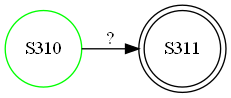

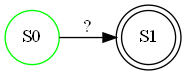

In [622]:

display(Image(filename=f'{nfa_image_file}.png'))
display(Image(filename=f'{minimized_dfa_image_file}.png'))
